# Jupyter Notebook for BTCGraphGuard

**Authors: Xuhui Zhan, Tianhao Qu, Siyu Yang**


## Import Libraries

In [1]:
import pandas as pd
import networkx as nx
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import LabelEncoder
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report
)

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [8]:
# Prepare Data
data_root = 'data/data/elliptic_bitcoin_dataset'
elliptic_txs_features = pd.read_csv(os.path.join(data_root, 'elliptic_txs_features.csv'), header=None)
elliptic_txs_edgelist = pd.read_csv(os.path.join(data_root, 'elliptic_txs_edgelist.csv'))
elliptic_txs_classes = pd.read_csv(os.path.join(data_root, 'elliptic_txs_classes.csv'))

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]


In [3]:
print(elliptic_txs_features.shape)
print(elliptic_txs_edgelist.shape)
print(elliptic_txs_classes.shape)


(203769, 167)
(234355, 2)
(203769, 2)


In [4]:
elliptic_txs_classes['class_mapped'] = elliptic_txs_classes['class'].replace({'1': 'illicit', '2': 'licit'})

In [5]:
# Create Graph
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, 'txId1', 'txId2')

## Random seed settings

In [6]:
RANDOM_STATE = 42
NUM_EPOCHS = 30

In [7]:
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def set_seed_for_numpy(seed):
    np.random.seed(seed) 
    
def set_seed_for_random(seed):
    random.seed(seed)  

In [8]:
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

## EDA

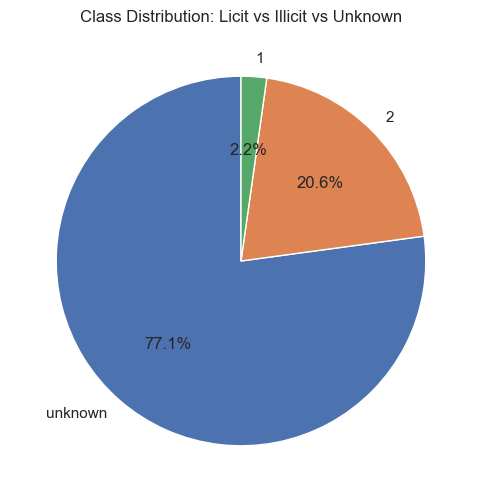

Graph has 203769 nodes and 234355 edges.


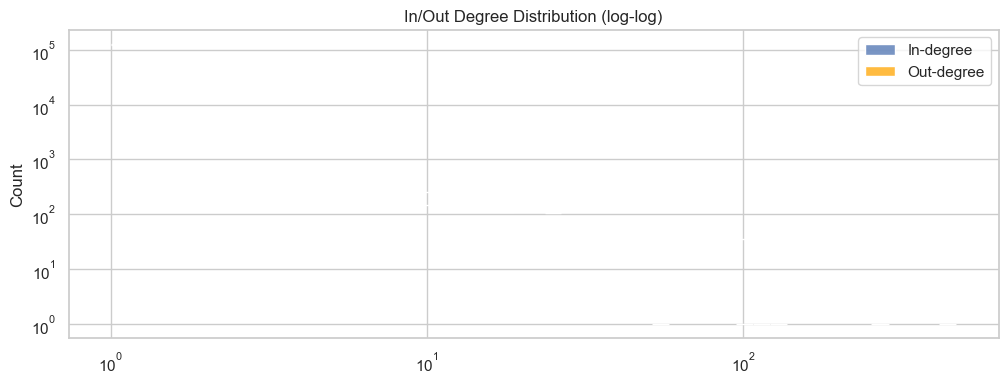

Weakly connected components: 49
Strongly connected components: 203769
Largest weakly connected component size: 7880
Louvain communities detected in largest component: 74


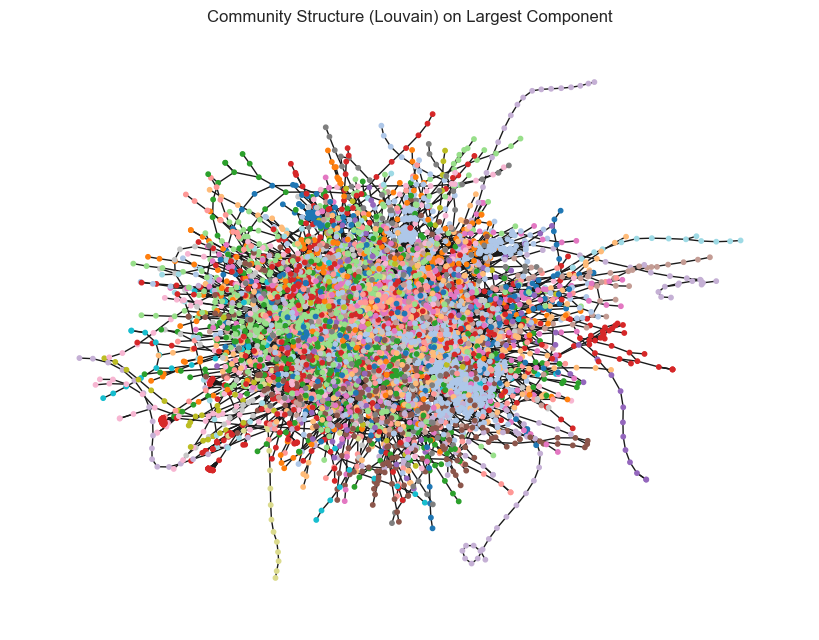

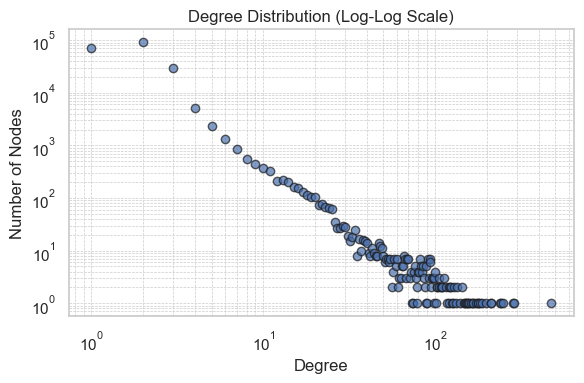

In [13]:
import community.community_louvain as community_louvain
import seaborn as sns
# -------------------------- #
# Initial Feature Processing #
# -------------------------- #

elliptic_txs_features.rename(columns={0: "txId"}, inplace=True)
features_df = elliptic_txs_features.set_index("txId")
elliptic_txs_classes.columns = ["txId", "class"]

# --------------------- #
# Class Distribution    #
# --------------------- #

plt.figure(figsize=(6, 6))
elliptic_txs_classes["class"].value_counts().plot.pie(autopct="%.1f%%", startangle=90)
plt.title("Class Distribution: Licit vs Illicit vs Unknown")
plt.ylabel("")
plt.show()

# --------------------- #
# Graph Construction    #
# --------------------- #

elliptic_txs_edgelist.columns = ["txId1", "txId2"]
G = nx.from_pandas_edgelist(elliptic_txs_edgelist, source="txId1", target="txId2", create_using=nx.DiGraph())

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

# --------------------- #
# Degree Distributions  #
# --------------------- #

in_degrees = [d for _, d in G.in_degree()]
out_degrees = [d for _, d in G.out_degree()]

plt.figure(figsize=(12, 4))
sns.histplot(in_degrees, bins=50, log_scale=(True, True), label="In-degree")
sns.histplot(out_degrees, bins=50, log_scale=(True, True), color="orange", label="Out-degree")
plt.legend()
plt.title("In/Out Degree Distribution (log-log)")
plt.show()

# --------------------- #
# Connected Components  #
# --------------------- #

num_weak = nx.number_weakly_connected_components(G)
num_strong = nx.number_strongly_connected_components(G)
largest_weak_cc = max(nx.weakly_connected_components(G), key=len)

print(f"Weakly connected components: {num_weak}")
print(f"Strongly connected components: {num_strong}")
print(f"Largest weakly connected component size: {len(largest_weak_cc)}")

# -------------------------- #
# Louvain Community Detection
# -------------------------- #

# Convert to undirected graph for community detection
G_undirected = G.to_undirected()
subgraph = G_undirected.subgraph(list(largest_weak_cc)).copy()

partition = community_louvain.best_partition(subgraph)
num_comms = len(set(partition.values()))
print(f"Louvain communities detected in largest component: {num_comms}")

# Optional: visualize one sample community
plt.figure(figsize=(8, 6))
nx.draw_spring(subgraph, node_color=list(partition.values()), node_size=10, cmap=plt.cm.tab20)
plt.title("Community Structure (Louvain) on Largest Component")
plt.show()
# Get degree for each node
degrees = [G.degree(n) for n in G.nodes()]

# Count frequency of each degree
degree_counts = np.bincount(degrees)
degrees_range = np.arange(len(degree_counts))

# Filter out zero-degree to avoid log(0)
nonzero_degrees = degrees_range[degree_counts > 0]
nonzero_counts = degree_counts[degree_counts > 0]

plt.figure(figsize=(6, 4))
plt.scatter(nonzero_degrees, nonzero_counts, alpha=0.7, edgecolors='k')
plt.xscale('log')
plt.yscale('log')
plt.title('Degree Distribution (Log-Log Scale)')
plt.xlabel('Degree')
plt.ylabel('Number of Nodes')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# EDA

## 1. Class Distribution Pie Chart
Breakdown:

Unknown: 77.1%

Illicit (2): 20.6%

Licit (1): 2.2%

Insight:

This dataset is extremely imbalanced, with most transactions unlabeled.

The known classes (licit vs illicit) are also highly skewed, with illicit > licit, which is unusual for many fraud detection datasets and may imply a specific labeling strategy or sample bias.

Next Step Suggestions:

When modeling, consider semi-supervised or transductive GNNs (e.g., GraphSAGE, APPNP).

Use class weights or sampling strategies to balance during training.

Investigate how labels were assigned — was it based on entities or behavior?

## 2. In/Out Degree Distribution (Log-Log Histogram)

Observation:

Both in-degrees and out-degrees follow a power-law distribution, typical of real-world financial networks.

A small number of nodes have extremely high degrees, suggesting hubs or aggregators.

Insight:

This confirms the network is scale-free, meaning certain nodes dominate connectivity (like exchanges, mixers, or payment hubs).

Potential for centrality-based feature engineering.

Next Step Suggestions:

Compute PageRank, betweenness centrality, or in/out ratios.

Flag high-degree nodes for further manual inspection — some may correspond to known exchange services.

## 3. Louvain Community Structure (Largest Component)
Observation:

Dense core with many fine-grained color groups (communities).

Some trailing edges indicate fringe or newly joined nodes.

Insight:

There is strong community structure, implying transaction clusters.

These may reflect co-conspirators, money laundering chains, or service-specific behavior (e.g., a cluster of darknet markets).

Next Step Suggestions:

Compute community IDs as categorical node features.

Check if any communities are dominated by illicit nodes — they could signal fraud rings.

## Preprocess Data

In [10]:
tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

# Create an explicit copy of the filtered DataFrame
edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys())) & 
                                           elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))].copy()

# Now use loc to set values (though with copy() above, direct assignment would also work)
edges_with_features.loc[:, 'Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features.loc[:, 'Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

In [11]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values, 
                             dtype=torch.float)

In [12]:
le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

In [13]:
data = Data(x=node_features, 
            edge_index=edge_index, 
            y=node_labels)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
known_mask   = (data.y == 0) | (data.y == 1)  # Only nodes with known labels licit or illicit
unknown_mask = data.y == 2                    # Nodes with unknown labels

In [16]:
num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)
val_size = int(0.1 * num_known_nodes)
test_size = num_known_nodes - train_size - val_size

total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)


In [17]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

print(len(data.train_mask))

203769


## Preliminary Results by Baseline Models GCN

In [18]:
# ------------------------------------------- #
# Training, Evaluation and prediction methods #
# ------------------------------------------- #

def train(model, data, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        correct = (pred[mask] == data.y[mask]).sum().item()
        accuracy = correct / mask.sum().item()

        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()

        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    return metrics

def predict(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
    return pred

def predict_probabilities(model, data):
    model.eval()
    with torch.no_grad():
        out = model(data)
        probabilities = torch.exp(out)
    return probabilities

In [19]:
def train_gnn(num_epochs, data, model, optimizer, criterion):
    
    train_losses = []
    train_accuracies = []
    train_precisions = []
    train_recalls = []
    train_f1_scores = []

    val_accuracies = []
    val_precisions = []
    val_recalls = []
    val_f1_scores = []

    # ----- #
    # Train #
    # ----- #

    for epoch in range(1, num_epochs + 1):
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], 
                         data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # --- Calculate training metrics ---
        pred_train = out[data.train_mask].argmax(dim=1)
        correct_train = (pred_train == data.y[data.train_mask]).sum()
        train_acc = int(correct_train) / int(data.train_mask.sum())
        train_accuracies.append(train_acc)

        y_true_train = data.y[data.train_mask].cpu().numpy()
        y_pred_train = pred_train.cpu().numpy()

        train_prec = precision_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_rec = recall_score(y_true_train, y_pred_train, average='weighted', zero_division=0)
        train_f1 = f1_score(y_true_train, y_pred_train, average='weighted', zero_division=0)

        train_precisions.append(train_prec)
        train_recalls.append(train_rec)
        train_f1_scores.append(train_f1)
        train_losses.append(loss.item())

        # --- Validate and calculate validation metrics ---
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred_val = out[data.val_mask].argmax(dim=1)
            correct_val = (pred_val == data.y[data.val_mask]).sum()
            val_acc = int(correct_val) / int(data.val_mask.sum())
            val_accuracies.append(val_acc)

            y_true_val = data.y[data.val_mask].cpu().numpy()
            y_pred_val = pred_val.cpu().numpy()

            val_prec = precision_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_rec = recall_score(y_true_val, y_pred_val, average='weighted', zero_division=0)
            val_f1 = f1_score(y_true_val, y_pred_val, average='weighted', zero_division=0)

            val_precisions.append(val_prec)
            val_recalls.append(val_rec)
            val_f1_scores.append(val_f1)

        if epoch % 10 == 0:        
            print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Train - Acc: {train_acc:.4f} - Prec: {train_prec:.4f} - Rec: {train_rec:.4f} - F1: {train_f1:.4f}')
            print(f'                         Val   - Acc: {val_acc:.4f} - Prec: {val_prec:.4f} - Rec: {val_rec:.4f} - F1: {val_f1:.4f}')        

    return {
        'train': {
            'losses': train_losses,
            'accuracies': train_accuracies,
            'precisions': train_precisions,
            'recalls': train_recalls,
            'f1_scores': train_f1_scores,
        },
        'val': {
            'accuracies': val_accuracies,
            'precisions': val_precisions,
            'recalls': val_recalls,
            'f1_scores': val_f1_scores,            
        }
    }

In [20]:
def plot_train_val_test_metrics(train_val_metrics, test_metrics, num_epochs):
    plt.figure(figsize=(10, 6))

    # --- Accuracy ----
    plt.subplot(2, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['accuracies'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['accuracies'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['accuracy'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(fontsize=8)
    plt.title('Accuracy')

    # --- Precision ---
    plt.subplot(2, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['precisions'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['precisions'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['precision'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Precision')
    plt.legend(fontsize=8)
    plt.title('Precision')

    # --- Recall ---
    plt.subplot(2, 2, 3)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['recalls'], color='C0', linewidth=1.0, label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['recalls'], color='C1', linewidth=1.0, label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['recall'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.legend(fontsize=8)
    plt.title('Recall')

    # --- F1-Score ---
    plt.subplot(2, 2, 4)
    plt.plot(range(1, num_epochs + 1), train_val_metrics['train']['f1_scores'], linewidth=1.0, color='C0', label='Training')
    plt.plot(range(1, num_epochs + 1), train_val_metrics['val']['f1_scores'], linewidth=1.0, color='C1', label='Validation', linestyle=':')
    plt.axhline(y=test_metrics['f1_score'], color='C2', linewidth=0.5, linestyle='--', label='Test')
    plt.xlabel('Epoch')
    plt.ylabel('F1-Score')
    plt.legend(fontsize=8)
    plt.title('F1-Score')

    plt.tight_layout()
    plt.show()

In [35]:
mapped_classes = np.array(['illicit', 'licit'])

In [36]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)
        self.conv2 = GCNConv(16, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


# ---------- #
# Initialize #
# ---------- #

model = GCN(num_node_features=data.num_features, num_classes=len(le.classes_)).to(device)
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=0.01, 
                             weight_decay=0.0005)
criterion = torch.nn.CrossEntropyLoss()  # Since we have a multiclass classification problem.

data = data.to(device)

In [37]:
# ----- #
# Train #
# ----- #

train_val_metrics = train_gnn(NUM_EPOCHS, 
                              data, 
                              model, 
                              optimizer, 
                              criterion)

Epoch 010, Loss: 0.2950, Train - Acc: 0.8835 - Prec: 0.8808 - Rec: 0.8835 - F1: 0.8821
                         Val   - Acc: 0.8924 - Prec: 0.8764 - Rec: 0.8924 - F1: 0.8819
Epoch 020, Loss: 0.2534, Train - Acc: 0.8995 - Prec: 0.8924 - Rec: 0.8995 - F1: 0.8955
                         Val   - Acc: 0.8928 - Prec: 0.8848 - Rec: 0.8928 - F1: 0.8883
Epoch 030, Loss: 0.2201, Train - Acc: 0.9152 - Prec: 0.9005 - Rec: 0.9152 - F1: 0.9024
                         Val   - Acc: 0.9049 - Prec: 0.8900 - Rec: 0.9049 - F1: 0.8927


In [38]:
# -------- #
# Evaluate on test set #
# -------- #

model.eval()
with torch.no_grad():
    
    test_metrics = evaluate(model, data, data.test_mask)
    test_acc = test_metrics.get('accuracy')
    test_prec = test_metrics.get('precision')
    test_rec = test_metrics.get('recall')
    test_f1 = test_metrics.get('f1_score')

    print(f'Test Acc: {test_acc:.4f} - Prec: {test_prec:.4f} - Rec: {test_rec:.4f} - F1: {test_f1:.4f}')

Test Acc: 0.9251 - Prec: 0.9152 - Rec: 0.9251 - F1: 0.9173


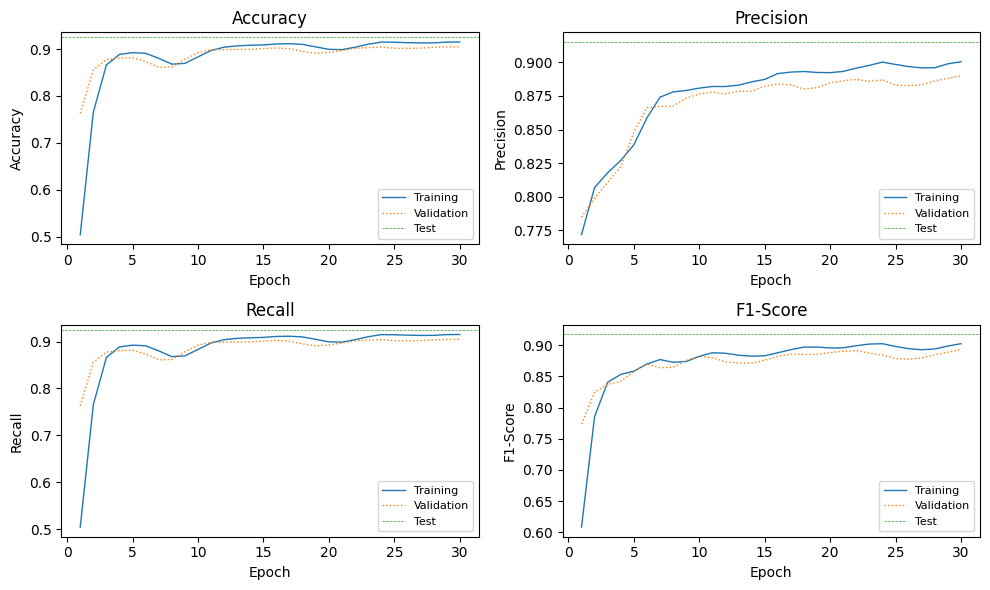

In [39]:
plot_train_val_test_metrics(train_val_metrics, test_metrics, NUM_EPOCHS)

In [40]:
train_pred = predict(model, data)[data.train_mask]
test_pred = predict(model, data)[data.test_mask]

In [41]:
print(le.inverse_transform([0])) # illicit
print(le.inverse_transform([1])) # licit 
print(le.inverse_transform([2])) # unknown

['1']
['2']
['unknown']


In [42]:
# --- Classification report ---
print("Classification Report")
print("=====================\n")

# Train.
y_true_train = data.y[data.train_mask].cpu().numpy()
y_pred_train = train_pred.cpu().numpy()

report_train = classification_report(y_true_train, y_pred_train, target_names=mapped_classes)

print(f"{4*' '}TRAIN")
print("---------")
print(report_train)

# Test.
y_true_test = data.y[data.test_mask].cpu().numpy()
y_pred_test = test_pred.cpu().numpy()

report_test = classification_report(y_true_test, y_pred_test, target_names=mapped_classes)

print(f"{4*' '}TEST")
print("--------")
print(report_test)

Classification Report

    TRAIN
---------
              precision    recall  f1-score   support

     illicit       0.62      0.37      0.46      3602
       licit       0.94      0.98      0.95     33649

    accuracy                           0.92     37251
   macro avg       0.78      0.67      0.71     37251
weighted avg       0.90      0.92      0.91     37251

    TEST
--------
              precision    recall  f1-score   support

     illicit       0.66      0.41      0.51       435
       licit       0.94      0.98      0.96      4222

    accuracy                           0.93      4657
   macro avg       0.80      0.70      0.73      4657
weighted avg       0.92      0.93      0.92      4657


# 